In [1]:
import torch
from torch import nn
from torch.nn.parameter import Parameter
from torch import distributions

import numpy as np
torch.manual_seed(0)
np.random.seed(0)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

from realnvp import RealNVP
from datasets import make_circles_ssl, make_moons_ssl, make_github_cat, make_npz
from distributions import SSLGaussMixture

%load_ext autoreload
%autoreload 2

In [2]:
class Nets(nn.Module):
    def __init__(self, D, inner_dim, inner_layers):
        super().__init__()
        self.seq_part = nn.Sequential(nn.Linear(D, inner_dim),
                                 nn.ReLU(),
                                 *inner_seq(inner_layers, inner_dim),
                                 nn.Linear(inner_dim, D),
                                 nn.Tanh())
        self.scale = nn.Parameter(torch.ones(D))
        
    
    def forward(self, x):
        x = self.seq_part.forward(x)
        x = self.scale * x
        return x

def inner_seq(n, inner_dim):
    res = []
    for _ in range(n):
        res.append(nn.Linear(inner_dim, inner_dim))
        res.append(nn.ReLU())
    return res

def get_toy_nvp(D, coupling_layers_num=6, inner_dim=256, inner_layers=2, prior=None, device=None):

    # a function that take no arguments and return a pytorch model, dim(X) -> dim(X)
    nets = lambda: Nets(D, inner_dim, inner_layers)
    nett = lambda: nn.Sequential(nn.Linear(D, inner_dim),
                                 nn.ReLU(),
                                 *inner_seq(inner_layers, inner_dim),
                                 nn.Linear(inner_dim, D))
    
    if prior is None:
        prior = distributions.MultivariateNormal(torch.zeros(D).to(device),
                                                 torch.eye(D).to(device))
        
    d = D // 2
    masks = torch.zeros(coupling_layers_num, D)
    for i in range(masks.size(0)):
        if i % 2:
            masks[i, :d] = 1.
        else:
            masks[i, d:] = 1.
    masks.to(device)
    return RealNVP(nets, nett, masks, prior, device=device)

In [3]:
def grid_image(mapping, xx, yy, extradim=False):
    lines = np.hstack([xx.reshape([-1, 1]), yy.reshape([-1, 1])])
    if extradim:
        lines = lines[:, None, :]
    lines = torch.from_numpy(lines).float()
    img_lines = mapping(lines).detach().numpy()
    
    if extradim:
        img_xx, img_yy = img_lines[:, 0, 0], img_lines[:, 0, 1]
    else:
        img_xx, img_yy = img_lines[:, 0], img_lines[:, 1]
    img_xx = img_xx.reshape(xx.shape)
    img_yy = img_yy.reshape(yy.shape)
    return img_xx, img_yy

In [ ]:
from scipy.spatial.distance import cdist

def get_decision_boundary(f_xx, f_yy, means):
    f_points = np.hstack([f_xx.reshape([-1, 1]), f_yy.reshape([-1, 1])])
    dists = cdist(f_points, means)
    dists.shape
    classes = np.argmin(dists, axis=1)
    return classes

## Moons

In [52]:
r = 3.5
means = torch.tensor([[-r, -r], [r, r]])
prior = SSLGaussMixture(means=means)

data, labels = make_moons_ssl()

flow = get_toy_nvp(D=2, prior=prior, device=None, inner_dim=256, coupling_layers_num=6, inner_layers=2)

In [54]:
lr_init = 1e-4
epochs = 2001

n_ul = np.sum(labels == -1)
n_l = np.shape(labels)[0] - n_ul
batch_size = n_l
print_freq = 500
label_weight = 1.
print(label_weight)

labeled_data = data[labels != -1]
labeled_labels = labels[labels != -1]
unlabeled_data = data[labels == -1]
unlabeled_labels = labels[labels == -1]

optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=lr_init, 
                             weight_decay=1e-2)
for t in range(epochs):    
    
    batch_idx = np.random.choice(n_ul, size=batch_size)
    batch_x, batch_y = unlabeled_data[batch_idx], unlabeled_labels[batch_idx]
    batch_x = np.vstack([batch_x, labeled_data])
    batch_y = np.hstack([batch_y, labeled_labels])
    batch_x, batch_y = torch.from_numpy(batch_x), torch.from_numpy(batch_y)
    

    loss = -flow.log_prob(batch_x, batch_y, label_weight).mean()
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if t % print_freq == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)
        
    if t == int(epochs * 0.5) or t == int(epochs * 0.8):
        for p in optimizer.param_groups:
            p["lr"] /= 10

1.0
iter 0: loss = 12.679
iter 500: loss = 0.363
iter 1000: loss = 0.328
iter 1500: loss = -0.027
iter 2000: loss = -0.259


(-2.5, 2.5)

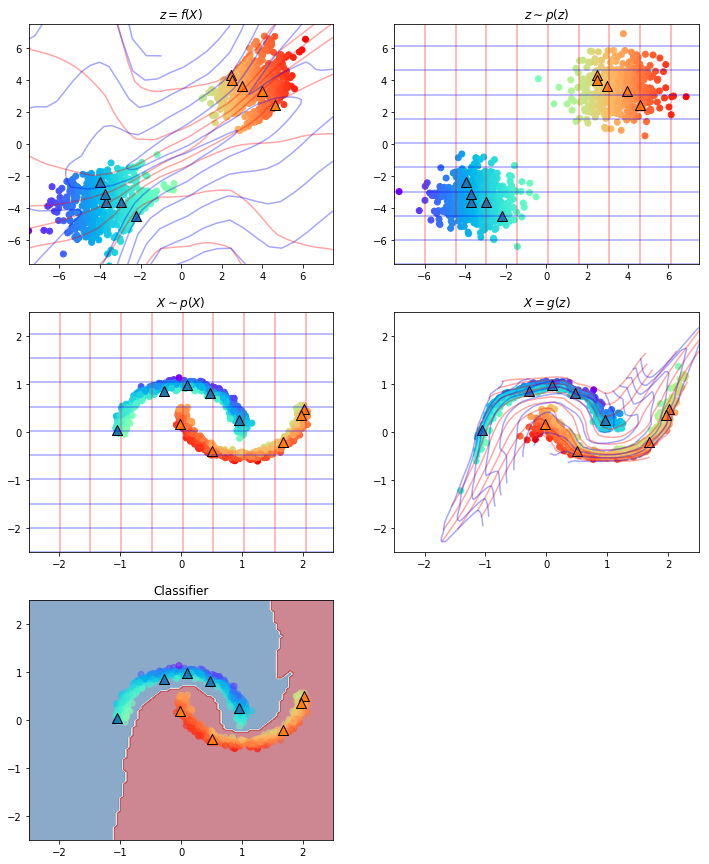

In [57]:
plt.figure(figsize=(12, 15))


grid_points = 100
grid_freq = 10
z_lims = [-7.5, 7.5]
x_lims = [-2.5, 2.5]
line_z = np.linspace(*z_lims, grid_points)
line_x = np.linspace(*x_lims, grid_points)
xx_z, yy_z = np.meshgrid(line_z, line_z)
xx_x, yy_x = np.meshgrid(line_x, line_x)


inv = flow.f(torch.from_numpy(data))[0].detach().numpy()


plt.subplot(321)
plt.scatter(inv[:, 0], inv[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(inv[labels==i][:, 0], inv[labels==i][:, 1], marker="^", s=100, edgecolor="k")
f_xx, f_yy = grid_image(lambda x: flow.f(x)[0], xx_x, yy_x)
plt.plot(f_xx[:, ::grid_freq], f_yy[:, ::grid_freq], '-r', alpha=0.35)
f_xx, f_yy = grid_image(lambda x: flow.f(x)[0], yy_x, xx_x)
plt.plot(f_xx[:, ::grid_freq], f_yy[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$z = f(X)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

z = flow.prior.sample((1000, 1)).numpy()
plt.subplot(322)
plt.scatter(z[:, 0, 0], z[:, 0, 1], c=z[:, 0, 0], cmap=plt.cm.rainbow)
plt.plot(xx_z[:, ::grid_freq], yy_z[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_z[:, ::grid_freq], xx_z[:, ::grid_freq], '-b', alpha=0.35)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(inv[labels==i][:, 0], inv[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'$z \sim p(z)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

plt.subplot(323)
plt.scatter(data[:, 0], data[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.plot(xx_x[:, ::grid_freq], yy_x[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_x[:, ::grid_freq], xx_x[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$X \sim p(X)$')
plt.xlim(x_lims)
plt.ylim(x_lims)

plt.subplot(324)
x = flow.g(torch.from_numpy(z).float()).detach().numpy()
g_xx, g_yy = grid_image(flow.g, xx_z, yy_z)
plt.plot(g_xx[:, ::grid_freq], g_yy[:, ::grid_freq], '-r', alpha=0.35)
g_xx, g_yy = grid_image(flow.g, yy_z, xx_z)
plt.plot(g_xx[:, ::grid_freq], g_yy[:, ::grid_freq], '-b', alpha=0.35)
plt.scatter(x[:, 0, 0], x[:, 0, 1], c=z[:, 0, 0], cmap=plt.cm.rainbow)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'$X = g(z)$')
plt.xlim(x_lims)
plt.ylim(x_lims)

plt.subplot(325)
f_xx, f_yy = grid_image(lambda x: flow.f(x)[0], xx_x, yy_x)
classes = get_decision_boundary(f_xx, f_yy, means.numpy())
plt.contourf(xx_x, yy_x, classes.reshape(xx_x.shape), cmap="RdBu_r", alpha=0.5)
# plt.colorbar()
plt.scatter(data[:, 0], data[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow, alpha=0.5)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'Classifier')
plt.xlim(x_lims)
plt.ylim(x_lims)

## Circles

In [58]:
r = 3.5
means = torch.tensor([[r, -r], [-r, r]])
prior = SSLGaussMixture(means=means)

data, labels = make_circles_ssl()

flow = get_toy_nvp(D=2, prior=prior, device=None, inner_dim=256, coupling_layers_num=6, inner_layers=2)

In [59]:
plt.figure(figsize=(12, 15))


grid_points = 100
grid_freq = 10
z_lims = [-7.5, 7.5]
x_lims = [-2.5, 2.5]
line_z = np.linspace(*z_lims, grid_points)
line_x = np.linspace(*x_lims, grid_points)
xx_z, yy_z = np.meshgrid(line_z, line_z)
xx_x, yy_x = np.meshgrid(line_x, line_x)


inv = flow.f(torch.from_numpy(data))[0].detach().numpy()


plt.subplot(321)
plt.scatter(inv[:, 0], inv[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(inv[labels==i][:, 0], inv[labels==i][:, 1], marker="^", s=100, edgecolor="k")
f_xx, f_yy = grid_image(lambda x: flow.f(x)[0], xx_x, yy_x)
plt.plot(f_xx[:, ::grid_freq], f_yy[:, ::grid_freq], '-r', alpha=0.35)
f_xx, f_yy = grid_image(lambda x: flow.f(x)[0], yy_x, xx_x)
plt.plot(f_xx[:, ::grid_freq], f_yy[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$z = f(X)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

z = flow.prior.sample((1000, 1)).numpy()
plt.subplot(322)
plt.scatter(z[:, 0, 0], z[:, 0, 1], c=z[:, 0, 0], cmap=plt.cm.rainbow)
plt.plot(xx_z[:, ::grid_freq], yy_z[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_z[:, ::grid_freq], xx_z[:, ::grid_freq], '-b', alpha=0.35)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(inv[labels==i][:, 0], inv[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'$z \sim p(z)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

plt.subplot(323)
plt.scatter(data[:, 0], data[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.plot(xx_x[:, ::grid_freq], yy_x[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_x[:, ::grid_freq], xx_x[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$X \sim p(X)$')
plt.xlim(x_lims)
plt.ylim(x_lims)

plt.subplot(324)
x = flow.g(torch.from_numpy(z).float()).detach().numpy()
g_xx, g_yy = grid_image(flow.g, xx_z, yy_z)
plt.plot(g_xx[:, ::grid_freq], g_yy[:, ::grid_freq], '-r', alpha=0.35)
g_xx, g_yy = grid_image(flow.g, yy_z, xx_z)
plt.plot(g_xx[:, ::grid_freq], g_yy[:, ::grid_freq], '-b', alpha=0.35)
plt.scatter(x[:, 0, 0], x[:, 0, 1], c=z[:, 0, 0], cmap=plt.cm.rainbow)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'$X = g(z)$')
plt.xlim(x_lims)
plt.ylim(x_lims)

plt.subplot(325)
f_xx, f_yy = grid_image(lambda x: flow.f(x)[0], xx_x, yy_x)
classes = get_decision_boundary(f_xx, f_yy, means.numpy())
plt.contourf(xx_x, yy_x, classes.reshape(xx_x.shape), cmap="RdBu_r", alpha=0.5)
# plt.colorbar()
plt.scatter(data[:, 0], data[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow, alpha=0.5)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'Classifier')
plt.xlim(x_lims)
plt.ylim(x_lims)

1.0
iter 0: loss = 13.845
iter 500: loss = 0.105
iter 1000: loss = 0.157
iter 1500: loss = 0.269
iter 2000: loss = 0.385
iter 2500: loss = 0.219
iter 3000: loss = 0.805
iter 3500: loss = 0.386
iter 4000: loss = 0.429
iter 4500: loss = -0.073
iter 5000: loss = 0.078


(-2.5, 2.5)

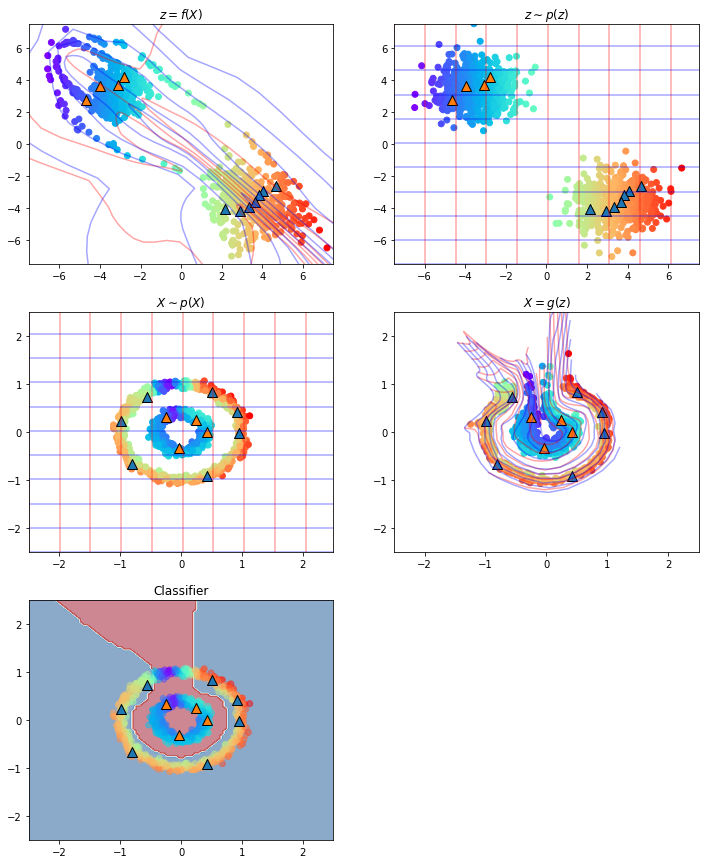

In [60]:
plt.figure(figsize=(12, 15))


grid_points = 100
grid_freq = 10
z_lims = [-7.5, 7.5]
x_lims = [-2.5, 2.5]
line_z = np.linspace(*z_lims, grid_points)
line_x = np.linspace(*x_lims, grid_points)
xx_z, yy_z = np.meshgrid(line_z, line_z)
xx_x, yy_x = np.meshgrid(line_x, line_x)


inv = flow.f(torch.from_numpy(data))[0].detach().numpy()


plt.subplot(321)
plt.scatter(inv[:, 0], inv[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(inv[labels==i][:, 0], inv[labels==i][:, 1], marker="^", s=100, edgecolor="k")
f_xx, f_yy = grid_image(lambda x: flow.f(x)[0], xx_x, yy_x)
plt.plot(f_xx[:, ::grid_freq], f_yy[:, ::grid_freq], '-r', alpha=0.35)
f_xx, f_yy = grid_image(lambda x: flow.f(x)[0], yy_x, xx_x)
plt.plot(f_xx[:, ::grid_freq], f_yy[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$z = f(X)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

z = flow.prior.sample((1000, 1)).numpy()
plt.subplot(322)
plt.scatter(z[:, 0, 0], z[:, 0, 1], c=z[:, 0, 0], cmap=plt.cm.rainbow)
plt.plot(xx_z[:, ::grid_freq], yy_z[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_z[:, ::grid_freq], xx_z[:, ::grid_freq], '-b', alpha=0.35)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(inv[labels==i][:, 0], inv[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'$z \sim p(z)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

plt.subplot(323)
plt.scatter(data[:, 0], data[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.plot(xx_x[:, ::grid_freq], yy_x[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_x[:, ::grid_freq], xx_x[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$X \sim p(X)$')
plt.xlim(x_lims)
plt.ylim(x_lims)

plt.subplot(324)
x = flow.g(torch.from_numpy(z).float()).detach().numpy()
g_xx, g_yy = grid_image(flow.g, xx_z, yy_z)
plt.plot(g_xx[:, ::grid_freq], g_yy[:, ::grid_freq], '-r', alpha=0.35)
g_xx, g_yy = grid_image(flow.g, yy_z, xx_z)
plt.plot(g_xx[:, ::grid_freq], g_yy[:, ::grid_freq], '-b', alpha=0.35)
plt.scatter(x[:, 0, 0], x[:, 0, 1], c=z[:, 0, 0], cmap=plt.cm.rainbow)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'$X = g(z)$')
plt.xlim(x_lims)
plt.ylim(x_lims)

plt.subplot(325)
f_xx, f_yy = grid_image(lambda x: flow.f(x)[0], xx_x, yy_x)
classes = get_decision_boundary(f_xx, f_yy, means.numpy())
plt.contourf(xx_x, yy_x, classes.reshape(xx_x.shape), cmap="RdBu_r", alpha=0.5)
# plt.colorbar()
plt.scatter(data[:, 0], data[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow, alpha=0.5)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'Classifier')
plt.xlim(x_lims)
plt.ylim(x_lims)

## 8 Gaussians

In [104]:
r = 5.5
n_classes = 3

phis = np.linspace(0, 2 * np.pi, n_classes+1)[:-1]
mean_x = np.cos(phis) * r
mean_y = np.sin(phis) * r
means = np.hstack([mean_x[:, None], mean_y[:, None]])
means = torch.from_numpy(means).float()
prior = SSLGaussMixture(means=means)

data, labels = make_npz("8gauss.npz")
# labels[labels == 1] = 3
# labels[labels == 2] = 1
# labels[labels == 3] = 2

flow = get_toy_nvp(D=2, prior=prior, device=None, inner_dim=256, coupling_layers_num=3, inner_layers=2)

In [105]:
lr_init = 1e-4
epochs = 5001

n_ul = np.sum(labels == -1)
n_l = np.shape(labels)[0] - n_ul
batch_size = n_l
print_freq = 500
label_weight = 1.
print(label_weight)

labeled_data = data[labels != -1]
labeled_labels = labels[labels != -1]
unlabeled_data = data[labels == -1]
unlabeled_labels = labels[labels == -1]

optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=lr_init, 
                             weight_decay=1e-2)
for t in range(epochs):    
    
    batch_idx = np.random.choice(n_ul, size=batch_size)
    batch_x, batch_y = unlabeled_data[batch_idx], unlabeled_labels[batch_idx]
    batch_x = np.vstack([batch_x, labeled_data])
    batch_y = np.hstack([batch_y, labeled_labels])
    batch_x, batch_y = torch.from_numpy(batch_x), torch.from_numpy(batch_y)
    

    loss = -flow.log_prob(batch_x, batch_y, label_weight).mean()
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if t % print_freq == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)
        
    if t == int(epochs * 0.5) or t == int(epochs * 0.8):
        for p in optimizer.param_groups:
            p["lr"] /= 10

1.0
iter 0: loss = 21.917
iter 500: loss = 2.886
iter 1000: loss = 2.900
iter 1500: loss = 2.720
iter 2000: loss = 2.886
iter 2500: loss = 2.777
iter 3000: loss = 2.723
iter 3500: loss = 2.743
iter 4000: loss = 2.803
iter 4500: loss = 2.770
iter 5000: loss = 2.677


(-4.5, 4.5)

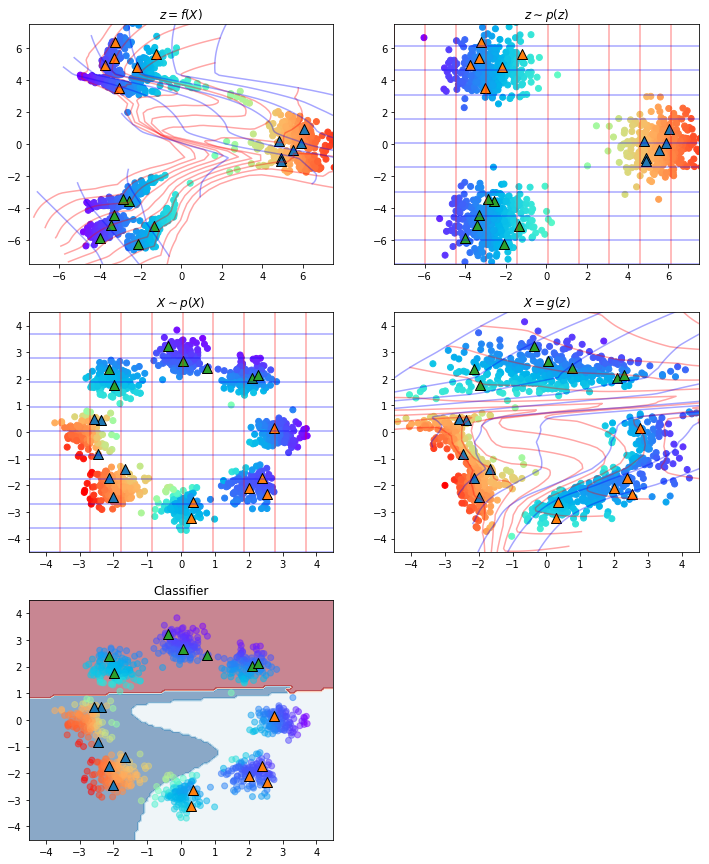

In [106]:
plt.figure(figsize=(12, 15))


grid_points = 100
grid_freq = 10
z_lims = [-7.5, 7.5]
x_lims = [-4.5, 4.5]
line_z = np.linspace(*z_lims, grid_points)
line_x = np.linspace(*x_lims, grid_points)
xx_z, yy_z = np.meshgrid(line_z, line_z)
xx_x, yy_x = np.meshgrid(line_x, line_x)


inv = flow.f(torch.from_numpy(data))[0].detach().numpy()


plt.subplot(321)
plt.scatter(inv[:, 0], inv[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(inv[labels==i][:, 0], inv[labels==i][:, 1], marker="^", s=100, edgecolor="k")
f_xx, f_yy = grid_image(lambda x: flow.f(x)[0], xx_x, yy_x)
plt.plot(f_xx[:, ::grid_freq], f_yy[:, ::grid_freq], '-r', alpha=0.35)
f_xx, f_yy = grid_image(lambda x: flow.f(x)[0], yy_x, xx_x)
plt.plot(f_xx[:, ::grid_freq], f_yy[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$z = f(X)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

z = flow.prior.sample((1000, 1)).numpy()
plt.subplot(322)
plt.scatter(z[:, 0, 0], z[:, 0, 1], c=z[:, 0, 0], cmap=plt.cm.rainbow)
plt.plot(xx_z[:, ::grid_freq], yy_z[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_z[:, ::grid_freq], xx_z[:, ::grid_freq], '-b', alpha=0.35)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(inv[labels==i][:, 0], inv[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'$z \sim p(z)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

plt.subplot(323)
plt.scatter(data[:, 0], data[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.plot(xx_x[:, ::grid_freq], yy_x[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_x[:, ::grid_freq], xx_x[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$X \sim p(X)$')
plt.xlim(x_lims)
plt.ylim(x_lims)

plt.subplot(324)
x = flow.g(torch.from_numpy(z).float()).detach().numpy()
g_xx, g_yy = grid_image(flow.g, xx_z, yy_z)
plt.plot(g_xx[:, ::grid_freq], g_yy[:, ::grid_freq], '-r', alpha=0.35)
g_xx, g_yy = grid_image(flow.g, yy_z, xx_z)
plt.plot(g_xx[:, ::grid_freq], g_yy[:, ::grid_freq], '-b', alpha=0.35)
plt.scatter(x[:, 0, 0], x[:, 0, 1], c=z[:, 0, 0], cmap=plt.cm.rainbow)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'$X = g(z)$')
plt.xlim(x_lims)
plt.ylim(x_lims)

plt.subplot(325)
f_xx, f_yy = grid_image(lambda x: flow.f(x)[0], xx_x, yy_x)
classes = get_decision_boundary(f_xx, f_yy, means.numpy())
plt.contourf(xx_x, yy_x, classes.reshape(xx_x.shape), cmap="RdBu_r", alpha=0.5)
# plt.colorbar()
plt.scatter(data[:, 0], data[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow, alpha=0.5)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'Classifier')
plt.xlim(x_lims)
plt.ylim(x_lims)

## Pinwheel

In [107]:
r = 5.5
n_classes = 5

phis = np.linspace(0, 2 * np.pi, n_classes+1)[:-1]
mean_x = np.cos(phis) * r
mean_y = np.sin(phis) * r
means = np.hstack([mean_x[:, None], mean_y[:, None]])
means = torch.from_numpy(means).float()
prior = SSLGaussMixture(means=means)

data, labels = make_npz("pinwheel.npz")

flow = get_toy_nvp(D=2, prior=prior, device=None, inner_dim=256, coupling_layers_num=3, inner_layers=2)

In [93]:
lr_init = 1e-4
epochs = 10001

n_ul = np.sum(labels == -1)
n_l = np.shape(labels)[0] - n_ul
batch_size = n_l
print_freq = 500
label_weight = 1.
print(label_weight)

labeled_data = data[labels != -1]
labeled_labels = labels[labels != -1]
unlabeled_data = data[labels == -1]
unlabeled_labels = labels[labels == -1]

optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=lr_init, 
                             weight_decay=1e-2)
for t in range(epochs):    
    
    batch_idx = np.random.choice(n_ul, size=batch_size)
    batch_x, batch_y = unlabeled_data[batch_idx], unlabeled_labels[batch_idx]
    batch_x = np.vstack([batch_x, labeled_data])
    batch_y = np.hstack([batch_y, labeled_labels])
    batch_x, batch_y = torch.from_numpy(batch_x), torch.from_numpy(batch_y)
    

    loss = -flow.log_prob(batch_x, batch_y, label_weight).mean()
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if t % print_freq == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)
        
    if t == int(epochs * 0.5) or t == int(epochs * 0.8):
        for p in optimizer.param_groups:
            p["lr"] /= 10

1.0
iter 0: loss = 11.522
iter 500: loss = 1.555
iter 1000: loss = 2.536
iter 1500: loss = 1.314
iter 2000: loss = 1.528
iter 2500: loss = 1.772
iter 3000: loss = 1.757
iter 3500: loss = 1.655
iter 4000: loss = 1.257
iter 4500: loss = 1.607
iter 5000: loss = 1.483
iter 5500: loss = 1.488
iter 6000: loss = 1.399
iter 6500: loss = 1.387
iter 7000: loss = 1.646
iter 7500: loss = 1.270
iter 8000: loss = 1.238
iter 8500: loss = 1.360
iter 9000: loss = 1.152
iter 9500: loss = 1.234
iter 10000: loss = 1.200


(-4.5, 4.5)

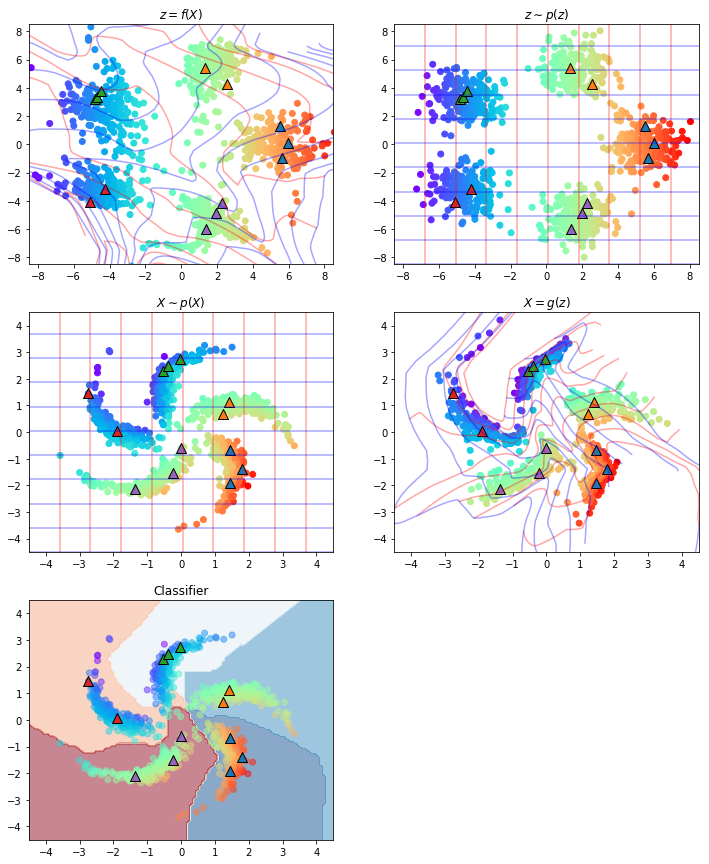

In [95]:
plt.figure(figsize=(12, 15))


grid_points = 100
grid_freq = 10
z_lims = [-8.5, 8.5]
x_lims = [-4.5, 4.5]
line_z = np.linspace(*z_lims, grid_points)
line_x = np.linspace(*x_lims, grid_points)
xx_z, yy_z = np.meshgrid(line_z, line_z)
xx_x, yy_x = np.meshgrid(line_x, line_x)


inv = flow.f(torch.from_numpy(data))[0].detach().numpy()


plt.subplot(321)
plt.scatter(inv[:, 0], inv[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(inv[labels==i][:, 0], inv[labels==i][:, 1], marker="^", s=100, edgecolor="k")
f_xx, f_yy = grid_image(lambda x: flow.f(x)[0], xx_x, yy_x)
plt.plot(f_xx[:, ::grid_freq], f_yy[:, ::grid_freq], '-r', alpha=0.35)
f_xx, f_yy = grid_image(lambda x: flow.f(x)[0], yy_x, xx_x)
plt.plot(f_xx[:, ::grid_freq], f_yy[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$z = f(X)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

z = flow.prior.sample((1000, 1)).numpy()
plt.subplot(322)
plt.scatter(z[:, 0, 0], z[:, 0, 1], c=z[:, 0, 0], cmap=plt.cm.rainbow)
plt.plot(xx_z[:, ::grid_freq], yy_z[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_z[:, ::grid_freq], xx_z[:, ::grid_freq], '-b', alpha=0.35)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(inv[labels==i][:, 0], inv[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'$z \sim p(z)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

plt.subplot(323)
plt.scatter(data[:, 0], data[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.plot(xx_x[:, ::grid_freq], yy_x[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_x[:, ::grid_freq], xx_x[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$X \sim p(X)$')
plt.xlim(x_lims)
plt.ylim(x_lims)

plt.subplot(324)
x = flow.g(torch.from_numpy(z).float()).detach().numpy()
g_xx, g_yy = grid_image(flow.g, xx_z, yy_z)
plt.plot(g_xx[:, ::grid_freq], g_yy[:, ::grid_freq], '-r', alpha=0.35)
g_xx, g_yy = grid_image(flow.g, yy_z, xx_z)
plt.plot(g_xx[:, ::grid_freq], g_yy[:, ::grid_freq], '-b', alpha=0.35)
plt.scatter(x[:, 0, 0], x[:, 0, 1], c=z[:, 0, 0], cmap=plt.cm.rainbow)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'$X = g(z)$')
plt.xlim(x_lims)
plt.ylim(x_lims)

plt.subplot(325)
f_xx, f_yy = grid_image(lambda x: flow.f(x)[0], xx_x, yy_x)
classes = get_decision_boundary(f_xx, f_yy, means.numpy())
plt.contourf(xx_x, yy_x, classes.reshape(xx_x.shape), cmap="RdBu_r", alpha=0.5)
# plt.colorbar()
plt.scatter(data[:, 0], data[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow, alpha=0.5)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'Classifier')
plt.xlim(x_lims)
plt.ylim(x_lims)

## Cat

In [61]:
means = torch.zeros((1, 2))
prior = SSLGaussMixture(means=means)

data, labels = make_github_cat("github.png")

flow = get_toy_nvp(D=2, prior=prior, device=None, inner_dim=256, coupling_layers_num=6, inner_layers=2)

In [62]:
lr_init = 3e-4
epochs = 2001
batch_size = 100
n_ul = np.sum(labels == -1)
n_l = np.shape(labels)[0] - n_ul
label_weight = 1.
print_freq = 500

optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=lr_init)
for t in range(epochs):    
    
    batch_idx = np.random.choice(n_l + n_ul, size=batch_size)
    batch_x, batch_y = data[batch_idx], labels[batch_idx]
    batch_x, batch_y = torch.from_numpy(batch_x).float(), torch.from_numpy(batch_y).float()
    
    loss = -flow.log_prob(batch_x, batch_y, label_weight).mean()
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if t % print_freq == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)
        
    if t == int(epochs * 0.5) or t == int(epochs * 0.8):
        for p in optimizer.param_groups:
            p["lr"] /= 10

iter 0: loss = 3.995
iter 500: loss = 3.282
iter 1000: loss = 3.241
iter 1500: loss = 3.243
iter 2000: loss = 3.183


(-4, 4)

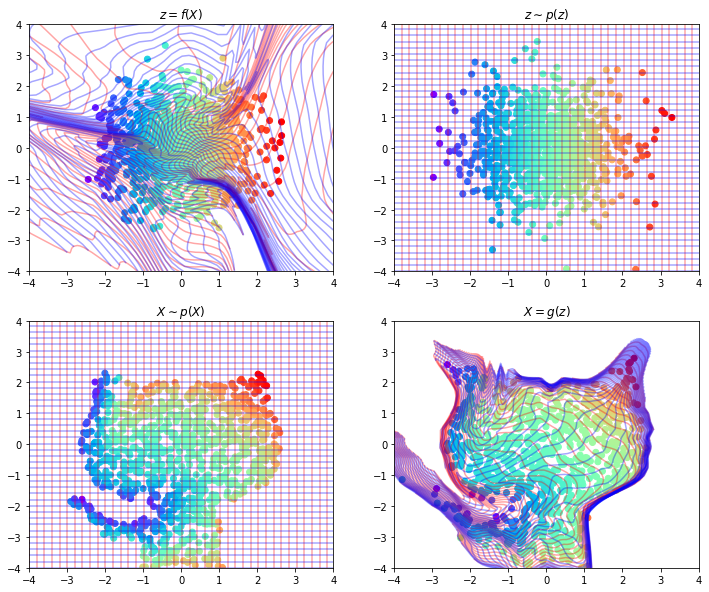

In [63]:
plt.figure(figsize=(12, 10))


grid_points = 200
grid_freq = 5
z_lims = [-4, 4]
x_lims = [-4, 4]
line_z = np.linspace(*z_lims, grid_points)
line_x = np.linspace(*x_lims, grid_points)
xx_z, yy_z = np.meshgrid(line_z, line_z)
xx_x, yy_x = np.meshgrid(line_x, line_x)


inv = flow.f(torch.from_numpy(data))[0].detach().numpy()


plt.subplot(221)
plt.scatter(inv[:, 0], inv[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
plt.scatter(inv[labels==0][:, 0], inv[labels==0][:, 1], marker="^", s=100, edgecolor="k")
plt.scatter(inv[labels==1][:, 0], inv[labels==1][:, 1], marker="^", s=100, edgecolor="k")
f_xx, f_yy = grid_image(lambda x: flow.f(x)[0], xx_x, yy_x)
plt.plot(f_xx[:, ::grid_freq], f_yy[:, ::grid_freq], '-r', alpha=0.35)
f_xx, f_yy = grid_image(lambda x: flow.f(x)[0], yy_x, xx_x)
plt.plot(f_xx[:, ::grid_freq], f_yy[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$z = f(X)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

z = flow.prior.sample((1000, 1)).numpy()
plt.subplot(222)
plt.scatter(z[:, 0, 0], z[:, 0, 1], c=z[:, 0, 0], cmap=plt.cm.rainbow)
plt.plot(xx_z[:, ::grid_freq], yy_z[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_z[:, ::grid_freq], xx_z[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$z \sim p(z)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

plt.subplot(223)
plt.scatter(data[:, 0], data[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
plt.scatter(data[labels==0][:, 0], data[labels==0][:, 1], marker="^", s=100, edgecolor="k")
plt.scatter(data[labels==1][:, 0], data[labels==1][:, 1], marker="^", s=100, edgecolor="k")
plt.plot(xx_x[:, ::grid_freq], yy_x[:, ::grid_freq], '-r', alpha=0.35)dummy
plt.plot(yy_x[:, ::grid_freq], xx_x[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$X \sim p(X)$')
plt.xlim(x_lims)
plt.ylim(x_lims)

plt.subplot(224)
x = flow.g(torch.from_numpy(z).float()).detach().numpy()
g_xx, g_yy = grid_image(flow.g, xx_z, yy_z)
plt.plot(g_xx[:, ::grid_freq], g_yy[:, ::grid_freq], '-r', alpha=0.35)
g_xx, g_yy = grid_image(flow.g, yy_z, xx_z)
plt.plot(g_xx[:, ::grid_freq], g_yy[:, ::grid_freq], '-b', alpha=0.35)
plt.scatter(x[:, 0, 0], x[:, 0, 1], c=z[:, 0, 0], cmap=plt.cm.rainbow)
plt.scatter(data[labels==0][:, 0], data[labels==0][:, 1], marker="^", s=100, edgecolor="k")
plt.scatter(data[labels==1][:, 0], data[labels==1][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'$X = g(z)$')
plt.xlim(x_lims)
plt.ylim(x_lims)